In [1]:
import pickle
import os
import cv2
import numpy as np
import PIL
from PIL import Image

#PIL.PILLOW_VERSION = PIL.__version__

from src.dataset import VDAODataset
from src import RESULT_DIR, DATA_DIR
from src.utils import MCC, DIS, conf_mat
import matplotlib.pyplot as plt
import pandas as pd
import torchvision.transforms as transforms

desired_output = (int(720 / 8), int(1280 / 8))
resize_transform = transforms.Resize(desired_output)

/home/luiz.tavares/.local/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: /nfs/home/luiz.tavares/.local/lib/python3.10/site-packages/torchvision/image.so: undefined symbol: _ZN3c104impl8GPUTrace13gpuTraceStateE
  warn(f"Failed to load image Python extension: {e}")


### Creating Silhouette test file

In [2]:
output_dir = os.path.join(RESULT_DIR, 'test_results')

for fold in range(1, 10):

    print(fold, end='\r')
    dataset = VDAODataset(fold = fold, split = 0, type = 'test',
                          alignment = 'warp', transform = False,
                          disable_crop=True)

    dd = dataset.align_df
    vid_list = dd.test_file.unique()

    for vid in vid_list:
        subfile_path =  os.path.join(output_dir, 'silhouette', 
                                     '{0:02d}.pkl'.format(int(vid)))
        idxs = list(dd[dd.test_file==vid].index)
        arr_full = np.array([dataset.__getitem__(ii)[2] for ii in idxs])

        # Saving progress
        out_dict = {'video': arr_full,
                    'video_num': vid,
                    'fold': fold,
                    'pre_subsampling': 1,
                    'cut_frame': 0,
                    'post_subsampling': 1}
        pickle.dump(out_dict, open(subfile_path, 'wb'))  
arr_full.sum(), arr_full[0].sum()

(2975194.5, 0.0)

In [ ]:
(46098237.5, 197764.0)


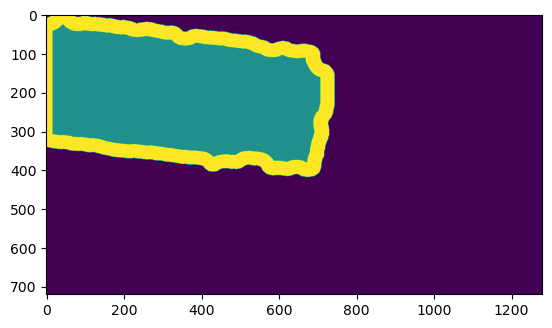

In [59]:
plt.imshow(arr[0])

### Creating Bounding box test file

In [ ]:
output_dir = os.path.join(RESULT_DIR, 'test_results')

for fold in range(9, 10):

    print(fold, end='\r')
    dataset = VDAODataset(fold = fold, split = 0, type = 'test',
                          alignment = 'warp', transform = False)
    
    dd = dataset.align_df
    vid_list = dd.test_file.unique()
    ref = np.array(dataset.__getitem__(0)[0])
    
    for vid in vid_list:
        align = dd[dd.test_file == vid]
        subfile_path =  os.path.join(output_dir, 'bbox', 
                                     '{0:02d}.pkl'.format(int(vid)))
        idxs = list(align.index)
        arr_full = np.zeros((201,720,1280))
        
        for ii,idx in enumerate(idxs):
            box_mask = np.zeros((720,1280))
            line = align.loc[idx,:]

            if not align.subbox_1.isna()[idx]:
                box = [int(k) if int(k)>0 else 0  for k in line.subbox_1.split(', ')]
                box_mask[box[1]:box[3], box[0]:box[2]] = 1
                
                if not align.subbox_2.isna()[idx]:
                    box = [int(k) if int(k)>0 else 0  for k in line.subbox_2.split(', ')]
                    box_mask[box[1]:box[3], box[0]:box[2]] = 1    
                
                if not align.subbox_3.isna()[idx]:
                    box = [int(k) if int(k)>0 else 0  for k in line.subbox_3.split(', ')]
                    box_mask[box[1]:box[3], box[0]:box[2]] = 1           
            else:
                if not align.bounding_box.isna()[idx]:
                    box = [int(k) if int(k)>0 else 0 for k in line.bounding_box.split(', ') ]
                    box_mask[box[1]:box[3], box[0]:box[2]] = 1
                
            arr_full[ii] = box_mask
            
        # w_border = (arr_full.shape[2] - ref.shape[1]) // 2
        # h_border = (arr_full.shape[1] - ref.shape[0]) // 2
        # arr_crop = arr_full[:, h_border:h_border + ref.shape[0],
        #                     w_border:w_border + ref.shape[1]]

        # arr = np.array([cv2.resize(ii, (160, 90), 
        #                         interpolation=cv2.INTER_AREA)
        #                 for ii in arr_crop])
        # arr[arr < 0.25] = 0
        # arr[arr >= 0.75] = 1
        # arr[(arr >= 0.25) & (arr < 0.75)] = 2
        
        # Saving progress
        out_dict = {'video': arr_full.astype(np.uint8),
                    'video_num': vid,
                    'fold': fold,
                    'pre_subsampling': 1,
                    'cut_frame': 0,
                    'post_subsampling': 1}
        pickle.dump(out_dict, open(subfile_path, 'wb'))  

In [9]:
align

,reference_file,target_file,silhouette_file,reference_frame,target_frame,target_obj,activity,test,bounding_box,subbox_1,subbox_2,subbox_3,num_pixels,test_file,test_frame,model_ransac,homography
402,7,1,1,1426,1305,1,False,True,NaN,NaN,NaN,NaN,0,10.0,0.0,"0.999999444517097,0.0010540234807945917,0.6776...","0.9999991053063471,0.0013376795226473625,-0.24..."
403,7,1,1,1427,1306,1,False,True,NaN,NaN,NaN,NaN,0,10.0,1.0,"0.9999993708569636,0.001121733336112106,0.5357...","0.9999982311104487,0.001880897651026612,-0.794..."
404,7,1,1,1429,1307,1,False,True,NaN,NaN,NaN,NaN,0,10.0,2.0,"0.9999989034090239,0.0014809391446640862,0.762...","0.9999994175338475,-0.0010793201407090388,0.04..."
405,7,1,1,1429,1308,1,False,True,NaN,NaN,NaN,NaN,0,10.0,3.0,"0.9999998933263753,0.0004618952676702678,0.062...","0.9999964856562841,-0.002651164853719339,0.805..."
406,7,1,1,1430,1309,1,False,True,NaN,NaN,NaN,NaN,0,10.0,4.0,"0.9999997310718154,0.0007333868672192258,-0.18...","0.9999980381192377,0.001980847716673204,-2.163..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
598,7,1,1,1621,1501,1,True,True,"0, 51, 436, 397",NaN,NaN,NaN,459843,10.0,196.0,"0.9999987446367234,-0.0015845267360335934,3.61...","0.9999999523400805,0.00030873910795829366,0.84..."
599,7,1,1,1621,1502,1,True,True,"0, 51, 439, 397",NaN,NaN,NaN,463293,10.0,197.0,"0.9999998547651987,-0.0005389522992551598,1.89...","0.9999990061764854,-0.0014098390123926307,1.65..."
600,7,1,1,1621,1503,1,True,True,"0, 51, 442, 397",NaN,NaN,NaN,466371,10.0,198.0,"0.9999997097096366,-0.0007619584255872095,-0.0...","0.9999992888950909,0.0011925641752268319,0.544..."
601,7,1,1,1621,1504,1,True,True,"0, 50, 445, 397",NaN,NaN,NaN,470280,10.0,199.0,"0.9999997001811946,0.0007743626551352319,0.745...","0.9999991853499348,-0.001276440154093363,2.193..."


In [8]:
not align.subbox_1.isna()[idx]

False

In [ ]:
output_dir = os.path.join(RESULT_DIR, 'test_results')

for fold in range(1, 10):

    print(fold, end='\r')
    dataset = VDAODataset(fold = fold, split = 0, type = 'test',
                          alignment = 'warp', transform = False)
    
    dd = dataset.align_df
    vid_list = dd.test_file.unique()
    ref = np.array(dataset.__getitem__(0)[0])
    
    for vid in vid_list:
        subfile_path =  os.path.join(output_dir, 'bbox_warp', 
                                     '{0:02d}.pkl'.format(int(vid)))
        idxs = list(dd[dd.test_file==vid].index)
        arr_full = np.zeros((201,720,1280))
        
        for idx in idxs:
            line = align.loc[idx,:]

            if not align.subbox_1.isna()[idx]:
                box = [int(k) if int(k)>0 else 0  for k in line.subbox_1.split(', ')]
                box_mask[box[1]:box[3], box[0]:box[2]] = 1
                
                if not align.subbox_2.isna()[idx]:
                    box = [int(k) if int(k)>0 else 0  for k in line.subbox_2.split(', ')]
                    box_mask[box[1]:box[3], box[0]:box[2]] = 1    
                
                if not align.subbox_3.isna()[idx]:
                    box = [int(k) if int(k)>0 else 0  for k in line.subbox_3.split(', ')]
                    box_mask[box[1]:box[3], box[0]:box[2]] = 1           
            else:
                box = [int(k) if int(k)>0 else 0 for k in line.bounding_box.split(', ') ]
                box_mask[box[1]:box[3], box[0]:box[2]] = 1
                
            arr_full[idx] = box_mask
            
        w_border = (arr_full.shape[2] - ref.shape[1]) // 2
        h_border = (arr_full.shape[1] - ref.shape[0]) // 2
        arr_crop = arr_full[:, h_border:h_border + ref.shape[0],
                            w_border:w_border + ref.shape[1]]

        # arr = np.array([cv2.resize(ii, (160, 90), 
        #                         interpolation=cv2.INTER_AREA)
        #                 for ii in arr_crop])
        arr[arr < 0.25] = 0
        arr[arr >= 0.75] = 1
        arr[(arr >= 0.25) & (arr < 0.75)] = 2
        
        # Saving progress
        out_dict = {'video': arr.astype(np.uint8),
                    'video_num': vid,
                    'fold': fold,
                    'pre_subsampling': 1,
                    'cut_frame': 0,
                    'post_subsampling': 1}
        pickle.dump(out_dict, open(subfile_path, 'wb'))  

In [11]:
base_dir =  '/home/luiz.tavares/Workspace/VDAO_Pixel_old/results/outputs/bbox/'
result_dict = {}
pickle.dump(result_dict, open(os.path.join(RESULT_DIR,'bbox.pkl'), 'wb'))


res_dict = {}
for fold in range(1, 10):

    print(fold, end='\r')
    temp_dict = {}
    dataset = VDAODataset(fold = fold, split = 0, type = 'test',
                          alignment = 'warp', transform = False)

    dd = dataset.align_df
    vid_list = dd.test_file.unique()

    for vid in vid_list:
        vv = int(vid)
        cap = cv2.VideoCapture(os.path.join(base_dir,
                                            '{0:02d}.avi'.format(vv)))
        idxs = list(range(0,201))
        arr = np.array([cap.read()[1] for ii in idxs]).astype('uint8')
        arr[arr > 127] = 255
        arr[arr <= 127] = 0
        temp_dict[vv] = arr
        
    # Saving progress
    res_dict = pickle.load(open(os.path.join(RESULT_DIR, 'test_results',
                                            'bbox.pkl'),'rb'))
    res_dict[int(fold)] = temp_dict
    pickle.dump(res_dict, open(os.path.join(RESULT_DIR, 'test_results',
                                            'bbox.pkl'), 'wb'))
    
    


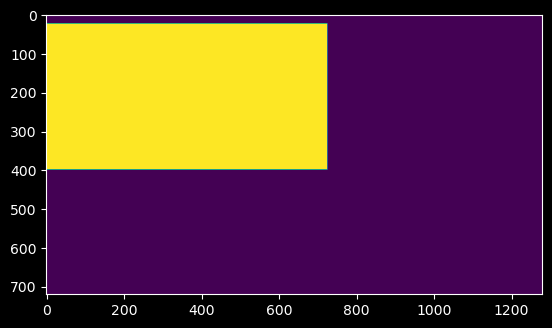

In [67]:
fold = 1
dataset = VDAODataset(fold = fold, split = 0, type = 'test',
                        alignment = 'warp', transform = False)
align = dataset.align_df
vid_list = align.test_file.unique()

vid = vid_list[0]
idxs = list(align[align.test_file==vid].index)

idx = idxs[0]
line = align.loc[idx,:]
box_mask = np.zeros((720,1280))

if not align.subbox_1.isna()[idx]:
    box = [int(k) if int(k)>0 else 0  for k in line.subbox_1.split(', ')]
    box_mask[box[1]:box[3], box[0]:box[2]] = 1
    
    if not align.subbox_2.isna()[idx]:
        box = [int(k) if int(k)>0 else 0  for k in line.subbox_2.split(', ')]
        box_mask[box[1]:box[3], box[0]:box[2]] = 1    
    
    if not align.subbox_3.isna()[idx]:
        box = [int(k) if int(k)>0 else 0  for k in line.subbox_3.split(', ')]
        box_mask[box[1]:box[3], box[0]:box[2]] = 1           
else:
    box = [int(k) if int(k)>0 else 0 for k in line.bounding_box.split(', ') ]
    box_mask[box[1]:box[3], box[0]:box[2]] = 1
    
plt.imshow(box_mask)

In [ ]:
import numpy as np
def calculate_diff(ref_frame_feat, tar_frame_feat, align, idx, lgbm, subbox=True, lg_class=True):

    feat_tar = resnet.get_features(tar_frame_feat[None, :], 'residual3')
    feat_ref = resnet.get_features(ref_frame_feat[None, :], 'residual3')
    
    if lg_class:

        feat     = torch.cat((feat_tar, feat_ref), 0)
        diff     = lgbm.predict(feat.view(512,-1).T.cpu().detach().numpy()).reshape((90,160))
    else:

        diff = torch.sqrt(((feat_tar - feat_ref)**2).sum(axis=0)).numpy()
        diff = (diff - diff.min())/(diff.max() - diff.min())
        
    diff = cv2.resize(diff, dsize=(1280,720), interpolation=cv2.INTER_CUBIC) 
    line = align.loc[idx,:]
    box_mask = np.zeros((720,1280))
    if subbox:
        if not align.subbox_1.isna()[idx]:
            box = [int(k) if int(k)>0 else 0  for k in line.subbox_1.split(', ')]
            box_mask[box[1]:box[3], box[0]:box[2]] = 1
            
            if not align.subbox_2.isna()[idx]:
                box = [int(k) if int(k)>0 else 0  for k in line.subbox_2.split(', ')]
                box_mask[box[1]:box[3], box[0]:box[2]] = 1    
            
            if not align.subbox_3.isna()[idx]:
                box = [int(k) if int(k)>0 else 0  for k in line.subbox_3.split(', ')]
                box_mask[box[1]:box[3], box[0]:box[2]] = 1           
        else:
            box = [int(k) if int(k)>0 else 0 for k in line.bounding_box.split(', ') ]
            box_mask[box[1]:box[3], box[0]:box[2]] = 1
    else:
        box = [int(k) if int(k)>0 else 0 for k in line.bounding_box.split(', ') ]
        box_mask[box[1]:box[3], box[0]:box[2]] = 1
  
    return box_mask*diff 
    


### Creating MCBS test file

In [24]:
base_dir =  '/nfs/proc/luiz.tavares/other_methods/MCBS/'
res_dict = {}
pickle.dump(res_dict, open(os.path.join(RESULT_DIR, 'test_results',
                                           'MCBS_Both.pkl'), 'wb'))

for fold in range(1,10):

    print(fold, end='\r')
    img_dir = os.path.join(base_dir,'fold{0:02d}/Both'.format(fold))

    temp_dict = {}
    dataset = VDAODataset(fold = fold, split = 0, type = 'test',
                         alignment = 'elastic', transform = False)

    dd = dataset.align_df
    vid_list = dd.test_file.unique()

    for vid in vid_list:
        idxs = list(dd[dd.test_file==vid].index)
        arr = [cv2.imread(os.path.join(img_dir, '{0}.png'.format(ii)))[:,:,0] 
               for ii in idxs]
        temp_dict[int(vid)] = np.array(arr).astype('uint8')
        
    # Saving progress
    res_dict = pickle.load(open(os.path.join(RESULT_DIR, 'test_results',
                                            'MCBS_Both.pkl'),'rb'))
    res_dict[int(fold)] = temp_dict
    pickle.dump(res_dict, open(os.path.join(RESULT_DIR, 'test_results',
                                            'MCBS_Both.pkl'), 'wb'))    

In [28]:
base_dir =  '/nfs/proc/luiz.tavares/other_methods/MCBS/'
res_dict = {}
pickle.dump(res_dict, open(os.path.join(RESULT_DIR, 'test_results',
                                           'MCBS_NVD.pkl'), 'wb'))

for fold in range(1,10):

    print(fold, end='\r')
    img_dir = os.path.join(base_dir,'fold{0:02d}/NVD'.format(fold))

    temp_dict = {}
    dataset = VDAODataset(fold = fold, split = 0, type = 'test',
                        alignment = 'elastic', transform = False)

    dd = dataset.align_df
    vid_list = dd.test_file.unique()

    for vid in vid_list:
        idxs = list(dd[dd.test_file==vid].index)
        arr = [cv2.imread(os.path.join(img_dir, '{0}.png'.format(ii)))[:,:,0] 
               for ii in idxs]
        temp_dict[int(vid)] = np.array(arr).astype('uint8')
        
    # Saving progress
    res_dict = pickle.load(open(os.path.join(RESULT_DIR, 'test_results',
                                            'MCBS_NVD.pkl'),'rb'))
    res_dict[int(fold)] = temp_dict
    pickle.dump(res_dict, open(os.path.join(RESULT_DIR, 'test_results',
                                            'MCBS_NVD.pkl'), 'wb'))    

In [ ]:
base_dir =  '/nfs/proc/luiz.tavares/other_methods/MCBS/' ## MUDAR
res_dict = {}
pickle.dump(res_dict, open(os.path.join(RESULT_DIR, 'test_results',
                                           'MCBS_NVD.pkl'), 'wb'))

for vid in range(1,60):

    print(fold, end='\r')
    img_dir = os.path.join(base_dir,'fold{0:02d}/NVD'.format(fold))

    temp_dict = {}
    dataset = VDAODataset(fold = fold, split = 0, type = 'test',
                        alignment = 'elastic', transform = False)

    dd = dataset.align_df
    vid_list = dd.test_file.unique()

    for vid in vid_list:
        idxs = list(dd[dd.test_file==vid].index)
        arr = [cv2.imread(os.path.join(img_dir, '{0}.png'.format(ii)))[:,:,0] 
               for ii in idxs]
        temp_dict[int(vid)] = np.array(arr).astype('uint8')
        
    # Saving progress
    res_dict = pickle.load(open(os.path.join(RESULT_DIR, 'test_results',
                                            'MCBS_NVD.pkl'),'rb'))
    res_dict[int(fold)] = temp_dict
    pickle.dump(res_dict, open(os.path.join(RESULT_DIR, 'test_results',
                                            'MCBS_NVD.pkl'), 'wb'))    

In [27]:
base_dir =  '/nfs/proc/luiz.tavares/other_methods/MCBS/'
res_dict = {}
pickle.dump(res_dict, open(os.path.join(RESULT_DIR, 'test_results',
                                           'MCBS_RRF.pkl'), 'wb'))

for fold in range(1,10):

    print(fold, end='\r')
    img_dir = os.path.join(base_dir,'fold{0:02d}/RRF'.format(fold))

    temp_dict = {}
    dataset = VDAODataset(fold = fold, split = 0, type = 'test',
                        alignment = 'elastic', transform = False)

    dd = dataset.align_df
    vid_list = dd.test_file.unique()

    for vid in vid_list:
        idxs = list(dd[dd.test_file==vid].index)
        arr = [cv2.imread(os.path.join(img_dir, '{0}.png'.format(ii)))[:,:,0] 
               for ii in idxs]
        temp_dict[int(vid)] = np.array(arr).astype('uint8')
        
    # Saving progress
    res_dict = pickle.load(open(os.path.join(RESULT_DIR, 'test_results',
                                            'MCBS_RRF.pkl'),'rb'))
    res_dict[int(fold)] = temp_dict
    pickle.dump(res_dict, open(os.path.join(RESULT_DIR, 'test_results',
                                            'MCBS_RRF.pkl'), 'wb'))    

### Creating mcDTSR test file

In [82]:
base_dir =  '/nfs/proc/luiz.tavares/other_methods/mcDTSR/'
modes = ['', 'e']
for mm in modes:
    res_dict = {}
    pickle.dump(res_dict, open(os.path.join(RESULT_DIR, 'test_results',
                                            'mcDTSR{0}.pkl'.format(mm)), 'wb'))
    for fold in range(1,10):

        print(fold, end='\r')
        temp_dict = {}
        dataset = VDAODataset(fold = fold, split = 0, type = 'test',
                            alignment = 'elastic', transform = False)

        dd = dataset.align_df
        vid_list = dd.test_file.unique()

        for vid in vid_list:
            img_dir = os.path.join(base_dir,'{0:02d}'.format(int(vid)))
            idxs = list(range(1,201))
            arr = [cv2.imread(os.path.join(img_dir, '{1}{0}.png'.format(ii, mm)))[:,:,0] 
                for ii in idxs]
            arr += arr[199]
            temp_dict[int(vid)] = np.array(arr).astype('uint8')
            
        # Saving progress
        res_dict = pickle.load(open(os.path.join(RESULT_DIR, 'test_results',
                                                'mcDTSR{0}.pkl'.format(mm)),'rb'))
        res_dict[int(fold)] = temp_dict
        pickle.dump(res_dict, open(os.path.join(RESULT_DIR, 'test_results',
                                                'mcDTSR{0}.pkl'.format(mm)), 'wb'))   


### Creating DAOMC test file

In [41]:
base_dir =  '/nfs/proc/luiz.tavares/other_methods/DAOMC/'
modes = ['']
for mm in modes:
    res_dict = {}
#    pickle.dump(res_dict, open(os.path.join(RESULT_DIR, 'test_results',
#                                            'DAOMC.pkl'), 'wb'))
    for fold in range(1,10):

        print(fold, end='\r')
        temp_dict = {}
        dataset = VDAODataset(fold = fold, split = 0, type = 'test',
                              alignment = 'elastic', transform = False)

        dd = dataset.align_df
        vid_list = dd.test_file.unique()

        for vid in vid_list:
            vv = int(vid)
            cap = cv2.VideoCapture(os.path.join(base_dir,
                                                '{0:02d}.mp4'.format(vv)))
            idxs = list(range(0,201))
            arr = [cap.read()[1] for ii in idxs]
            temp_dict[vv] = np.array(arr).astype('uint8')
            
        # Saving progress
        res_dict = pickle.load(open(os.path.join(RESULT_DIR, 'test_results',
                                                'DAOMC.pkl'),'rb'))
        res_dict[int(fold)] = temp_dict
        pickle.dump(res_dict, open(os.path.join(RESULT_DIR, 'test_results',
                                                'DAOMC.pkl'), 'wb'))   


#### Creating ADMULT test file

In [3]:
base_dir =  '/nfs/proc/luiz.tavares/other_methods/ADMULT/'
modes = ['']
for mm in modes:
    res_dict = {}
    pickle.dump(res_dict, open(os.path.join(RESULT_DIR, 'test_results',
                                           'ADMULT.pkl'), 'wb'))
    for fold in range(1,10):

        print(fold, end='\r')
        temp_dict = {}
        dataset = VDAODataset(fold = fold, split = 0, type = 'test',
                              alignment = 'elastic', transform = False)

        dd = dataset.align_df
        vid_list = dd.test_file.unique()

        for vid in vid_list:
            vv = int(vid)
            cap = cv2.VideoCapture(os.path.join(base_dir,
                                                '{0:02d}.mp4'.format(vv)))
            idxs = list(range(0,201))
            arr = [cap.read()[1] for ii in idxs]
            temp_dict[vv] = np.array(arr).astype('uint8')[:,:,:,0]
            
        # Saving progress
        res_dict = pickle.load(open(os.path.join(RESULT_DIR, 'test_results',
                                                'ADMULT.pkl'),'rb'))
        res_dict[int(fold)] = temp_dict
        pickle.dump(res_dict, open(os.path.join(RESULT_DIR, 'test_results',
                                                'ADMULT.pkl'), 'wb'))   


###  Creating Lightgbm test file

In [15]:
out_dir = os.path.join(DATA_DIR, 'test_classifier', 'result_data')
classifier = 'LightGBM'
alignment = 'warp'
res_dict = {}
for fold in range(1, 10):
        res_dict[fold] = {}
        out_file = os.path.join(
                out_dir, '{0}_{1}_fold{2:02d}.pkl'.format(classifier, alignment, fold))
        data = pickle.load(open(out_file, 'rb'))

        vid_list = data['prediction'].keys()
        
        for vv in vid_list:
               res_dict[fold][vv] =  data['prediction'][vv].numpy()
                
pickle.dump(res_dict, open(os.path.join(RESULT_DIR, 'test_results',
                                        'LightGBM_warp.pkl'), 'wb'))   


In [9]:
data['prediction'][1].shape

torch.Size([201, 90, 160])

### RESULTS

In [5]:
sil_dict = pickle.load(open(os.path.join(RESULT_DIR, 'test_results',
                                        'silhouette.pkl'),'rb'))


In [2]:
subsample = {'mcDTSR':1,'mcDTSRe':1, 'MCBS_Both':1, 'MCBS_RRF':1, 'DAOMC':1,
             'ADMULT':1, 'TCF_LMO':4, 'LightGBM_temporal':8,
             'LightGBM_warp':8}
results = {'mcDTSR':{}, 'mcDTSRe':{}, 'MCBS_Both':{}, 'MCBS_RRF':{},
           'DAOMC':{}, 'ADMULT':{}, 'TCF_LMO':{}, 'LightGBM_temporal':{},
           'LightGBM_warp':{}}


In [3]:
method = 'TCF_LMO'
res_dict = pickle.load(open(os.path.join(RESULT_DIR, 'test_results',
                                         '{0}.pkl'.format(method)),'rb'))

In [11]:
tn_sum, fp_sum, fn_sum, tp_sum = 0, 0, 0, 0
ss = subsample[method]
for fold in range(1,10):
    vids = list(sil_dict[fold].keys())
    for vid in vids:
        frame_out = res_dict[fold][vid][0]
        frame_sil = sil_dict[fold][vid][0]
        # out_y, out_x = frame_out.shape[0], frame_out.shape[1]
        # delta_x = (frame_sil.shape[1]//ss - out_x)//2
        # delta_y = (frame_sil.shape[0]//ss - out_y)//2

        # output_arr     = res_dict[fold][vid]
        # silhouette_arr = sil_dict[fold][vid][:,delta_y:delta_y+out_y:ss,
        #                                        delta_x:delta_x+out_x:ss]
        output_arr     = res_dict[fold][vid]
        silhouette_arr = sil_dict[fold][vid][:,::ss,::ss]

        silhouette = silhouette_arr.flatten()
        output = output_arr.flatten()

        output = output[silhouette != 127].flatten()//128
        silhouette = silhouette[silhouette != 127].flatten()//128

        tn, fp, fn, tp = conf_mat(silhouette, output).ravel()
        tn_sum += tn
        fp_sum += fp
        fn_sum += fn
        tp_sum += tp

        metric = DIS(tn, fp, fn, tp)
        results[method][vid] = metric
res_df = pd.DataFrame.from_dict(results[method],
                 orient='index', columns=['MCC']).sort_index(ascending=True)
res_df

,MCC
1,0.244942
2,0.624442
3,0.392435
4,0.242136
5,0.014732
6,0.009787
7,0.054389
8,0.935256
9,0.852106
10,0.205257


In [12]:
res_df.mean()

MCC    0.239292
dtype: float64

In [13]:
DIS(tn_sum, fp_sum, fn_sum, tp_sum), MCC(tn_sum, fp_sum, fn_sum, tp_sum)

(0.19211943243129104, 0.6121959615364108)

### ADMULT

In [5]:
base_dir =  '/home/luiz.tavares/Softwares/vad/video/admult/'

pickle.dump({}, open(os.path.join(RESULT_DIR, 'test_results',
                                 'ADMULT.pkl'), 'wb'))  
for fold in range(1,10):

    print(fold, end='\r')
    temp_dict = {}
    dataset = VDAODataset(fold = fold, split = 0, type = 'test',
                         alignment = 'elastic', transform = False)

    dd = dataset.align_df
    vid_list = dd.test_file.unique()

    for vid in vid_list:
        vid_dir = os.path.join(base_dir,'{0:02d}.avi'.format(int(vid)))
        cap = cv2.VideoCapture(vid_dir)
        arr = [cap.read()[1] for i in range(201)]

        temp_dict[int(vid)] = np.array(arr).astype('uint8')
        
    # Saving progress
    res_dict = pickle.load(open(os.path.join(RESULT_DIR, 'test_results',
                                            'ADMULT.pkl'),'rb'))
    res_dict[int(fold)] = temp_dict
    pickle.dump(res_dict, open(os.path.join(RESULT_DIR, 'test_results',
                                            'ADMULT.pkl'), 'wb'))  


/tmp/ipykernel_14144/1034829479.py:20: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  temp_dict[int(vid)] = np.array(arr).astype('uint8')


ValueError: setting an array element with a sequence.

### TCF_LMO

In [78]:
import glob

base_dir =  '/nfs/proc/rafael.padilla/resultados_luiz_11_abr_2023/'

pickle.dump({}, open(os.path.join(RESULT_DIR, 'test_results',
                                 'TCF_LMO.pkl'), 'wb'))  
for fold in range(1,10):

    print(fold, end='\r')
    temp_dict = {}
    dataset = VDAODataset(fold = fold, split = 0, type = 'test',
                          alignment = 'elastic', transform = False)

    dd = dataset.align_df
    vid_list = dd.test_file.unique()
    
    # path 
    fold_path = os.path.join(base_dir, 'fold_{0}'.format(fold))
    frm_paths = glob.glob(fold_path+
                          '/video_fold{0:02d}-frames_*/'.format(fold))
    frm_paths.sort()

    for j, vid in enumerate(vid_list):
        img_dir = os.path.join(fold_path, frm_paths[j], 'tcm')
        idxs = list(range(201))
        arr = [cv2.imread(os.path.join(img_dir, 
                                       '{0}_tcm.png'.format(ii)))[:,:,0] 
                for ii in idxs]
        temp_dict[int(vid)] = np.array(arr).astype('uint8')
        
    # Saving progress
    res_dict = pickle.load(open(os.path.join(RESULT_DIR, 'test_results',
                                            'TCF_LMO.pkl'),'rb'))
    res_dict[int(fold)] = temp_dict
    pickle.dump(res_dict, open(os.path.join(RESULT_DIR, 'test_results',
                                            'TCF_LMO.pkl'), 'wb'))   


In [10]:
base_dir =  '/nfs/proc/luiz.tavares/other_methods/mcDTSR/'

for folder in range(1,59):
    
    dir = os.path.join(base_dir, '{0:02d}'.format(folder))
    
    for i in range(1,201):
        img = os.path.join(dir, '{0}.png'.format(i))
        if not os.path.isfile(img):
            print('Video {0:02d} - Frame {1:03d}'.format(folder, i))
            
    for i in range(1,201):
        img = os.path.join(dir, 'e{0}.png'.format(i))
        if not os.path.isfile(img):
            print('Video {0:02d} - Frame e{1:03d}'.format(folder, i))


In [2]:
box_dict = pickle.load(open(os.path.join(RESULT_DIR, 'test_results',
                                        'bbox.pkl'),'rb'))


In [2]:
import numpy as np
import cv2
import sys
import os
import pickle
import pandas as pd

from src import RESULT_DIR
from src.utils import conf_mat

# Directories
output_dir = os.path.join(RESULT_DIR, 'test_results')


# dbases   = ['adamult', 'daomc', 'mcbs', 'mcDTSR']

# Subsampling
pre_ssample = {'ADMULT': 1, 'DAOMC': 1, 'MCBS_Both': 1,
               'mcDTSR': 4, 'LightGBM_temporal': 8, 'LightGBM_warp': 8, 
               'TCF_LMO': 4, 'bbox': 1, 'silhouette': 1}
cut_frame = {'ADMULT': 0, 'DAOMC': 0, 'MCBS_Both': 5,
             'mcDTSR': 0, 'LightGBM_temporal': 0, 'LightGBM_warp': 0, 
             'TCF_LMO': 0, 'bbox': 0, 'silhouette': 0}
post_ssample = {'ADMULT': 1, 'DAOMC': 1, 'MCBS_Both': 1,
                'mcDTSR': 1, 'LightGBM_temporal': 1, 'LightGBM_warp': 1, 
                'TCF_LMO': 1, 'bbox': 1, 'silhouette': 1}

dbase = 'LightGBM_warp'

# Loading
vid_path = os.path.join(output_dir, '{0}.pkl'.format(dbase))
vid = pickle.load(open(vid_path, 'rb'))

for fold in range(1, 10):
    print(fold, end='\r')
    videos =  list(vid[fold].keys())

    for vid_num in videos:

        vv = vid[fold][vid_num]

        subfile_path =  os.path.join(output_dir, dbase, 
                                     '{0:02d}.pkl'.format(vid_num))
        
        if dbase != 'silhouette':
            out_vid = vid[fold][vid_num]
            if vid[fold][vid_num].max() == 255:
                out_vid[out_vid < 127] = 0
                out_vid[out_vid >= 127] = 1
            else:
                out_vid[out_vid < 0.5] = 0
                out_vid[out_vid >= 0.5] = 1                
            out = out_vid.astype(bool)
        else:
            out_vid = vid[fold][vid_num]
            if vid[fold][vid_num].max() == 255:
                out_vid[out_vid < 50] = 0
                out_vid[(out_vid >= 50) & (out_vid < 200)] = 2
                out_vid[out_vid >= 200] = 1
            else:
                out_vid[out_vid < 0.33] = 0
                out_vid[out_vid >= 0.67] = 1
                out_vid[(out_vid >= 0.33) & (out_vid < 0.67)] = 2
            out = out_vid.astype(np.uint8)
        if out.ndim == 4:
            out = out[:, :, :, 0]
        out_dict = {'video': out,
                    'video_num': vid_num,
                    'fold': fold,
                    'pre_subsampling': pre_ssample[dbase],
                    'cut_frame': cut_frame[dbase],
                    'post_subsampling': post_ssample[dbase]}
        pickle.dump(out_dict, open(subfile_path, 'wb'))  

In [46]:
# DEBUG
sil_file = os.path.join(RESULT_DIR, 'test_results', 'silhouette', '02.pkl')
res_file = os.path.join(RESULT_DIR, 'test_results', 'LightGBM_warp', '02.pkl')
sil = pickle.load(open(sil_file, 'rb'))['video']
res = pickle.load(open(res_file, 'rb'))['video']


In [5]:
sil[0].sum(), res[0].sum(), arr[0].sum()

NameError: name 'arr' is not defined

In [7]:
out_dir = os.path.join(DATA_DIR, 'test_classifier', 'result_data')
out_file = os.path.join(
    out_dir, '{0}_{1}_fold{2:02d}.pkl'.format('LightGBM', 
                                              'warp', 1))
data = pickle.load(open(out_file, 'rb'))

In [8]:
sil_good = data['silhouette'][1].numpy()
sil_good[sil_good == 0.5] = 2

In [10]:
# confusion matrix
res_out = res.reshape(-1).astype(np.uint8)
sil_out = sil[:, ::8, ::8].reshape(-1)

valid_pix = np.where(sil_out != 2)[0]
tn, fp, fn, tp = conf_mat(sil_out[valid_pix], res_out[valid_pix]).ravel()

mcc = MCC(tn, fp, fn, tp)
dis = DIS(tn, fp, fn, tp)

mcc, dis, tn, fp, fn, tp

(0.8667251313028197,
 0.06580518367761382,
 1888070.0,
 117828.0,
 18034.0,
 589946.0)

In [58]:
dataset = VDAODataset(fold = 1, split = 0, type = 'test',
                      alignment = 'warp', transform = False)

dd = dataset.align_df
vid_list = dd.test_file.unique()


idxs = list(dd[dd.test_file==2].index)
arr_full = np.array([dataset.__getitem__(ii)[2] for ii in idxs])
ref = np.array(dataset.__getitem__(0)[0])

w_border = (arr_full.shape[2] - ref.shape[1]) // 2
h_border = (arr_full.shape[1] - ref.shape[0]) // 2
arr_crop = arr_full[:, h_border:h_border + ref.shape[0],
                    w_border:w_border + ref.shape[1]]

arr = np.array([cv2.resize(ii, (160, 90), 
                           interpolation=cv2.INTER_AREA)
                for ii in arr_crop])
arr[arr < 0.25] = 0
arr[arr >= 0.75] = 1
arr[(arr >= 0.25) & (arr < 0.75)] = 2


In [40]:
arr_crop.sum(), arr_crop[0].sum(), arr.sum(), arr[0].sum()

(46098237.5, 197764.0, 1330540.0, 5381.0)

In [ ]:
plt.figure(figsize=(16,9))
plt.imshow(sil[60])
plt.show()

In [59]:
res_out = res.reshape(-1).astype(np.uint8)
sil_out = arr.reshape(-1)

valid_pix = np.where(sil_out != 2)[0]
tn, fp, fn, tp = conf_mat(sil_out[valid_pix], res_out[valid_pix]).ravel()

mcc = MCC(tn, fp, fn, tp)
dis = DIS(tn, fp, fn, tp)

mcc, dis, tn, fp, fn, tp

(0.8825982768639148, 0.023075349021250566, 2658724.0, 14714.0, 1365.0, 59547.0)

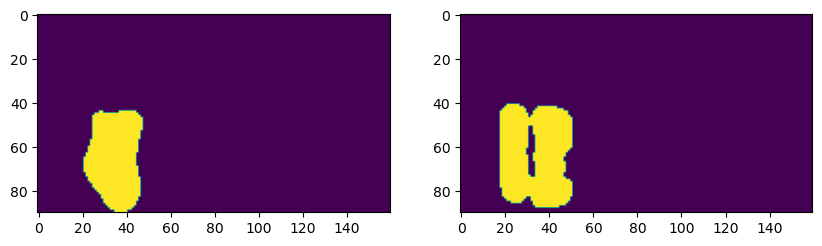

In [60]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,8))
ax1.imshow(res[170])
ax2.imshow(arr[170])

In [2]:
res_out = arr.reshape(-1).astype(np.uint8)
sil_out = sil[:, ::8, ::8].reshape(-1)

valid_pix = np.where(sil_out != 2)[0]
tn, fp, fn, tp = conf_mat(sil_out[valid_pix], res_out[valid_pix]).ravel()

mcc = MCC(tn, fp, fn, tp)
dis = DIS(tn, fp, fn, tp)

mcc, dis, tn, fp, fn, tp

NameError: name 'arr' is not defined

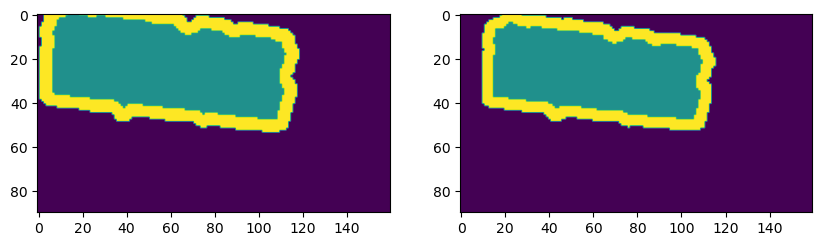

In [19]:
# sil_file = os.path.join(RESULT_DIR, 'test_results', 'silhouette', '01.pkl')
# sil = pickle.load(open(sil_file, 'rb'))['video'][0]

# plt.imshow(sil)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,8))
ax1.imshow(arr[60])
ax2.imshow(sil[60, ::8, ::8])
# ax3.imshow(arr.astype(np.uint8)-sil_good[0])

In [8]:
import numpy as np
import matplotlib.pyplot as plt

Total = 10000
Prop = 0.4
P = int(Prop*Total)
N = Total - P

# tp_rate = tp / (tp + fn)
# fp_rate = fp / (fp + tn)

# Create x and y values using linspace
tp_rate_ls  = np.linspace(0, 1, 100)
fp_rate_ls  = np.linspace(0, 1, 100)

tp_rate = tp_rate_ls[10]
fp_rate = tp_rate_ls[10]

tp = int(tp_rate*P)
fn = int(tp/tp_rate) - tp
fp = int(fp_rate*N)
tn = int(fp/fp_rate) - fp

N, P
# Create a grid of x and y values using meshgrid
# xx, yy = np.meshgrid(tp_rate, fp_rate)

# # Compute z values using a function of x and y
# dis = np.sqrt((1 - xx)**2 + yy**2)

# # Plot heatmap using pcolormesh
# plt.pcolormesh(xx, yy, dis, cmap='viridis')
# plt.colorbar()
# plt.show()

(6000, 4000)